In [7]:

import pandas as pd
import os

### SKLEARN ###
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split

### METRICS  ######
from sklearn.metrics import accuracy_score, recall_score, precision_score
### MODELS: ######
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [8]:
dataset_path = os.path.join("..", "Data", "titanic.csv")
titanic = pd.read_csv(dataset_path)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
# Defining the transformations: 
age_imputer = SimpleImputer(strategy="median")
embarked_imputer = SimpleImputer(strategy="most_frequent")
one_hot_encoder = OneHotEncoder(drop="first") # we do this to avoid redundant features
pass_through = FunctionTransformer()
inputer= ColumnTransformer(
    transformers=[
        ("age_imputer", age_imputer, ["Age"]), # input age
        ("embarked_imputer", embarked_imputer, ["Embarked"])# input embarked
    ],
    remainder="passthrough", # let the other columns passthrough
    verbose_feature_names_out=False
).set_output(transform="pandas")

preprocessor_transformer = ColumnTransformer(
    transformers=[
        ("one hot", one_hot_encoder, ["Embarked", "Sex", "Pclass"]),
        ("selector", pass_through, ["Age", "SibSp", "Parch", "Fare"])
    ],
    remainder="drop"
)


preprocessor_pipeline = Pipeline(steps =[
    ("input_variables", inputer), 
    ("preprocessing", preprocessor_transformer), 

])


In [10]:
X_all = titanic.drop(columns=["Survived"])
y_all = titanic["Survived"]

#X_all.set_index('PassengerId', inplace=True)

X_all, X_oot, y_all, y_oot = train_test_split(X_all, y_all, test_size=0.1, random_state=2)

In [11]:
X_train,X_test, y_train, y_test = train_test_split(X_all, y_all,
                                                    test_size=0.2, random_state=23)

In [12]:
X_oot.merge(y_oot, right_index=True, left_index=True).to_csv("../Data/oot.csv", index=False)
X_train.merge(y_train, right_index=True, left_index=True).to_csv("../Data/train.csv", index=False)
X_test.merge(y_test, right_index=True, left_index=True).to_csv("../Data/test.csv", index=False)

In [13]:
class PreFixedPipeline(TransformerMixin, BaseEstimator): 
    def __init__(self, pipeline): 
        super()
        self.pipeline = pipeline
    
    def fit(self, X, y=None): 
        # in this case do nothing as the pipe 
        # is already fitted
        return self

    def transform(self, X): 
        return self.pipeline.transform(X)

In [14]:
preprocessor_pipeline = preprocessor_pipeline.fit(X_train)

X_train_transformed = preprocessor_pipeline.transform(X_train)
X_test_transformed = preprocessor_pipeline.transform(X_test)

In [15]:
X_train_transformed

array([[ 0.    ,  1.    ,  1.    , ...,  1.    ,  0.    , 66.6   ],
       [ 0.    ,  0.    ,  1.    , ...,  0.    ,  0.    , 12.875 ],
       [ 0.    ,  1.    ,  0.    , ...,  0.    ,  0.    ,  7.775 ],
       ...,
       [ 0.    ,  1.    ,  1.    , ...,  0.    ,  0.    ,  7.8958],
       [ 0.    ,  1.    ,  1.    , ...,  0.    ,  0.    ,  0.    ],
       [ 1.    ,  0.    ,  1.    , ...,  4.    ,  1.    , 29.125 ]])

In [16]:
prefitted_pipe = PreFixedPipeline(preprocessor_pipeline)

In [17]:
linsvc_pipe = Pipeline([("preprocessing", prefitted_pipe), 
                      ("svc", LinearSVC(dual="auto", max_iter=2000))])
rf_pipe = Pipeline([("preprocessing", prefitted_pipe), 
                      ("RF", RandomForestClassifier())])

In [18]:
linsvc_pipe.fit(X_train, y=y_train)
pred_linsvc = linsvc_pipe.predict(X_test)
acc_linsvc = accuracy_score(y_test, pred_linsvc)

print(acc_linsvc)

0.8198757763975155


In [19]:
rf_pipe = rf_pipe.fit(X_train, y=y_train)
pred_rf = rf_pipe.predict_proba(X_test)[:, 1]>0.35
acc_rf = accuracy_score(y_test, pred_rf)
recall_rf = recall_score(y_test, pred_rf)
precision_rf = precision_score(y_test, pred_rf)
print(acc_rf)
print(recall_rf)
print(precision_rf)

0.8385093167701864
0.7794117647058824
0.828125


In [20]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,recall_score
import matplotlib.pyplot as plt
def plot_precision_recall(model, X_train, y_train, cut_off=None):
  # Predict on train data
  y_scores=model.predict_proba(X_train)

  precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

  # Plot values of precisions, recalls, and thresholds
  plt.figure(figsize=(10,7))
  plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
  plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
  if cut_off:
    plt.axvline(cut_off, color="r", linestyle=":")
  plt.xlabel('Threshold')
  plt.legend(loc='upper left')
  plt.title("Recall vs Precision curve")
  plt.xticks(np.arange(0, 1, 0.1))
  plt.ylim([0,1])
  plt.show()

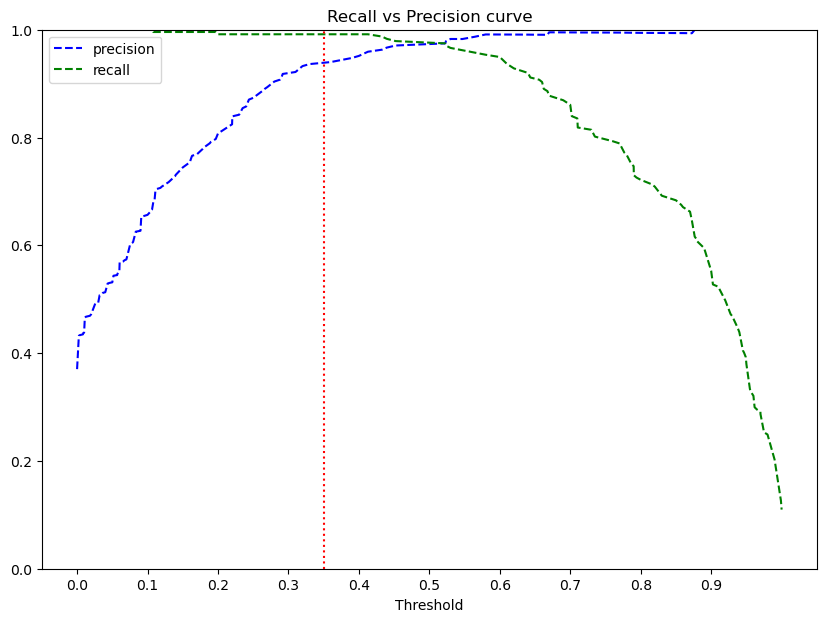

In [21]:
import numpy as np
plot_precision_recall(rf_pipe, X_train, y_train, cut_off=0.35)

In [22]:
import psutil
import time
# Function to monitor resource usage
def monitor_resources():
    process = psutil.Process()
    cpu_usage = process.cpu_percent(interval=)
    memory_usage = process.memory_info().rss / (1024 * 1024)  # Convert to MB
    return cpu_usage, memory_usage

# Initial resource usage
print("Initial resources:", monitor_resources())

# Fit the pipeline and monitor resources
start_time = time.time()
rf_pipe.fit(X_train, y_train)
end_time = time.time()

# Resource usage after pipeline execution
cpu_usage, memory_usage = monitor_resources()
print("Resources after execution: CPU usage: {:.2f}%, Memory usage: {:.2f} MB".format(cpu_usage, memory_usage))
print("Time taken: {:.2f} seconds".format(end_time - start_time))


SyntaxError: invalid syntax (345281583.py, line 6)

In [23]:
import psutil
import time
# Function to monitor resource usage
def monitor_resources():
    process = psutil.Process()
    cpu_usage = process.cpu_percent(interval=1)
    memory_usage = process.memory_info().rss / (1024 * 1024)  # Convert to MB
    return cpu_usage, memory_usage

# Initial resource usage
print("Initial resources:", monitor_resources())
cpu_usage_initial = psutil.cpu_percent(interval=1)
# Fit the pipeline and monitor resources
start_time = time.time()
rf_pipe.fit(X_train, y_train)
end_time = time.time()

# Resource usage after pipeline execution
cpu_usage_end = psutil.cpu_percent(interval=1)
print(cpu_usage_initial, cpu_usage_end)


Initial resources: (1.0, 239.98828125)
19.2 13.7


In [32]:
X_train.columns


Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [33]:
rf_pipe[1][0].feature_importances_

array([0.01362606, 0.02506754, 0.23805779, 0.00388222, 0.06301262,
       0.22967247, 0.03467143, 0.03435136, 0.35765852])

In [35]:
preprocessor_pipeline[0].get_feature_names_out()

array(['Age', 'Embarked', 'PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin'], dtype=object)